## Analysis
- Seasons of interest - June, July, August, September.
- Districts of interest - Kolhapur, Latur

- In this notebook, the rainfall of a month is predicted based on the month of previous years.

### Import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools

### Useful functions

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

### Dataset

In [5]:
PATH = 'Dataset/rainfall_data_1901_to_2002.xlsx'
data = pd.read_excel(PATH)

### Preprocess data

In [6]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))

m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')

districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [19]:
m_data = maharashtra_data.copy()

### Filter data
- Season - June, July, August, September.
- Kolhapur, Latur

In [32]:
districts_of_interest = ['Kolhapur', 'Latur']
months_of_interest = ['Jun', 'Jul', 'Aug', 'Sep']

In [33]:
rainfall_season_data = m_data[m_data.Month.isin(months_of_interest)]
rainfall_season_data = rainfall_season_data[['Date', 'Year', 'Month'] + districts_of_interest]

In [34]:
rainfall_season_data.head()

,Date,Year,Month,Kolhapur,Latur
5,1901-06-01,1901,Jun,554.047,188.878
6,1901-07-01,1901,Jul,496.636,175.092
7,1901-08-01,1901,Aug,507.657,138.084
8,1901-09-01,1901,Sep,221.539,102.949
17,1902-06-01,1902,Jun,631.349,46.720


### Parameters

In [98]:
future_steps = 10
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
#parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

### Run, Compare and Save output

FNN - Number of combinations: 15
1 -> [568.4463836649655, 635.1005719265341, 599.1548528991937, 594.8475226675271, 595.4935163190364, 589.856927883625, 590.2176191430688, 588.9394496029614, 588.481504586935, 588.2910735785364]
2 -> [599.6028978322148, 615.9210405310391, 609.6046816903352, 598.9499688284396, 599.2873657749294, 597.6805346556902, 596.8850338683128, 596.7226619186997, 596.5138072264193, 596.4325418391822]
3 -> [594.2929591943621, 623.5992696136235, 618.4489499611258, 602.5907111182808, 605.8119440084695, 603.1324627193212, 601.7645041911005, 601.8429636724591, 601.3570654808879, 601.2212702246903]
4 -> [605.0900320733784, 618.3082311342358, 625.0019049031733, 607.1439551764726, 617.0725207736491, 575.336603199452, 605.6874253174066, 598.8468385519981, 590.3537585197985, 601.0948456352949]
5 -> [590.308916967362, 614.7049715116024, 617.7552559096812, 599.3114542121887, 583.8778865769802, 606.6973926088214, 591.6766637291014, 592.6945457927584, 594.6002323588729, 594.505652

7 -> [559.9952598668932, 640.626618258655, 634.1941584445237, 597.572639633417, 626.6945543889999, 619.041525517702, 598.6638723120689, 615.606143773198, 607.2790621916055, 583.033388319969]
8 -> [540.2397501128017, 636.3625413308142, 606.5593738045692, 583.9992552416323, 601.8435460302829, 585.607198134899, 563.8845630642771, 590.0886268850862, 566.0273751479386, 558.3148663661777]
9 -> [543.8274978406727, 637.9762548606991, 630.6749701150059, 596.6359435445665, 628.8762256219982, 612.3234456617831, 589.609690516591, 608.8355987715124, 595.4701690644621, 576.1134420656562]
10 -> [533.2983095606266, 651.836424009919, 633.6781894125937, 586.6431068202852, 651.4369794843792, 613.3032891712188, 597.3873439621924, 621.7927956440448, 606.2807420566677, 579.9398241472542]
11 -> [534.6340531128644, 706.5591592932343, 640.3852044698596, 600.7789429866671, 665.1615651438832, 623.9798669223188, 582.8841458922028, 630.820559570968, 592.460702655673, 570.8738098996281]
12 -> [558.708328488618, 651

SANN - Number of combinations: 4
1 -> [715.3442633951307, 632.8922001547218, 655.2777930853367, 703.7346590880156, 662.667843429804, 649.4734387145043, 728.4223614147902, 666.9988758221865, 640.6608410588503, 641.537638572216]
2 -> [658.0346550420523, 664.4336259341836, 674.481987098217, 621.3048681709766, 640.2133698347807, 606.8642646629214, 681.5655204329491, 604.2209448302389, 682.9043518433572, 594.2920443097353]
3 -> [686.7308693862558, 742.0124503085614, 666.5176067367793, 662.2355578807593, 661.91541270113, 636.4833007971048, 627.6752199063301, 700.8728991607428, 651.8658834082485, 641.4455121437311]
4
[674.2755008555056, 673.2016400054694, 619.5627208069562, 661.107145413518, 635.0550685921908, 581.465522306323, 599.2989560536146, 677.6106644672752, 637.1810630956888, 630.2164452776909]
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 5.0
Output nodes: 12.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MS

2 -> [443.35375849723823, 421.32432681930067, 440.78152700951705, 451.835007282734, 457.35194476789246, 460.27347609001407, 450.06528094464545, 483.3264253081084, 455.41204335081585, 465.0265678782464]
3 -> [444.07422057208424, 422.15200129354, 444.900635267824, 449.1693159775735, 455.4621720369459, 457.53634484577185, 448.8125886991025, 481.0169626190961, 452.01825256365544, 463.63697970241316]
4 -> [448.88465852743394, 428.76379127639535, 446.99908505815273, 457.4842740011216, 462.4128424361945, 465.37757366269835, 455.4744023865462, 488.09416202139863, 461.0433057348133, 470.2195323259235]
5 -> [439.24756296855213, 437.47607818964127, 454.30737507897624, 446.81145679786806, 452.2720454405547, 452.2224941529036, 446.20894148504743, 474.61314107021695, 441.7491681241394, 461.46323190134774]
6 -> [438.5342658839226, 422.11557269859316, 419.05158142447476, 450.28986270758514, 446.2798040256501, 452.52373868662124, 448.18681997480996, 465.53667318904405, 465.22130863797673, 455.240818456

6 -> [234.54892015361781, 148.71570101177693, 170.5376232532263, 215.0860230025053, 221.85380789649486, 205.1193683296442, 207.6311443685889, 215.274193451643, 214.7252538704872, 209.8265544873476]
7 -> [278.0903921123743, 209.05465172708034, 184.963903642416, 231.08407680726052, 232.11944605278967, 215.62599280059337, 214.45674536430835, 218.52404056906698, 218.3292124238014, 212.343052197814]
8 -> [284.0105325064659, 197.24155885279177, 170.61701419031618, 213.32244386857747, 233.54512621587514, 220.95812491554022, 215.60854072266815, 216.28146944802998, 221.23550570714474, 220.2731064825654]
9 -> [278.46887795877456, 185.71754648715256, 167.6364416319728, 205.22972173219918, 226.2409092953801, 216.70299353927373, 211.82733145612477, 209.75773508030176, 213.56284519737957, 214.18882184398174]
10 -> [319.0295684356689, 183.19546355462074, 115.43549374365806, 188.42955482637882, 278.6027840059995, 277.3744529986381, 205.0668867417574, 177.4715719857216, 216.52826383650302, 247.52064714

11 -> [250.72090975177284, 213.10347809278966, 197.94198191320896, 184.53290835165976, 217.06923646748066, 258.4670138424635, 241.5248207286596, 205.72432727026938, 218.80378916054963, 240.91259124958512]
12 -> [246.50898375916478, 176.2473219510913, 184.0036772224307, 239.21336055940387, 237.09599033898112, 196.77145307934285, 214.96412309348582, 226.79065671414136, 215.94104946672917, 205.21630884230137]
13 -> [318.30126104962824, 182.1371127220392, 136.82660872551799, 173.53623287534714, 253.9674419493675, 230.91320522546766, 179.82373045641182, 215.83246494996547, 233.38251407718658, 230.62455649209022]
14 -> [276.933735800147, 190.16966488504409, 177.56993317830563, 222.59966485810278, 241.8748511918187, 216.8724305129051, 203.3490757866502, 246.73969103670117, 244.08951013076302, 220.86899814248085]
15
[301.66008494150634, 174.12627467674017, 143.5450458844006, 187.2436910062432, 254.39352057331797, 217.98940528482197, 202.8419348374605, 227.95560032594204, 240.38115945929286, 22

3 -> [123.58257142949104, 130.84329099869728, 154.79543035078046, 120.10868985390663, 138.41015131902694, 108.27763499939441, 117.02204655635356, 138.5028087515831, 116.19040897679328, 106.5304558622837]
4
[105.82844217014312, 123.93141775369644, 118.9147453792095, 88.85181122767925, 132.39709971666335, 106.25012258195876, 125.48695637404917, 141.70280891454217, 108.39744373250007, 110.53851347613335]
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 4.0
Output nodes: 12.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MSE): 1334.723
Mean Absolute Error(MAE): 27.112
Root Mean Squared Error(RMSE): 36.534



LSTM - Number of combinations: 15
1 -> [114.85652802062035, 128.76240403938291, 120.43346603417396, 135.2425589840412, 119.3629163134098, 120.82475065040587, 125.08935353064537, 122.03981775295733, 125.28179589056968, 123.03904055428504]
2 -> [120.47029142403602, 130.32714158272742, 119.20896242547035, 130.0123438

3 -> [151.8729929355383, 135.0913210658729, 133.70831035891177, 145.78583007386328, 141.82858377262951, 141.01928870314362, 156.01528217464687, 154.00522736158968, 146.7784560213983, 149.1528635047376]
4 -> [140.10376690632106, 141.81468535876274, 142.81408052745462, 147.62678605490925, 147.83464767733216, 148.14151025664808, 152.24005856215953, 147.65146605578065, 144.90413682323694, 148.0901484618783]
5 -> [135.29492448821665, 154.44173237878084, 125.81516143560411, 138.46399112448097, 134.75193812966347, 122.60403958618642, 144.3340823598504, 172.46647381919624, 161.20596661263704, 148.60784023398162]
6 -> [133.298855886966, 139.86244548904898, 144.74135066309572, 154.65003299090267, 152.01276725566387, 151.59293506723643, 156.7141010965109, 151.94331908529998, 148.62987751686575, 150.9649515231848]
7 -> [131.6185876953006, 127.59932970920205, 138.75087089270355, 159.11476016384364, 152.49179281508924, 155.60898842853308, 163.69163164526225, 141.63757935464383, 137.7486222909689, 15

6 -> [133.2784834089279, 132.1901920735836, 127.37323706269264, 126.87253451037405, 129.29490940785408, 130.90098321235178, 142.18613906884192, 143.0546710100174, 142.96186021757126, 142.01476726627348]
7 -> [141.9557308806181, 171.11704044282436, 159.2623998544216, 143.96215309035776, 149.35918656623363, 165.98678844034671, 167.20163193833827, 173.7918589338064, 152.77749350667, 159.40311370182036]
8 -> [141.62004609346388, 166.60873527657984, 155.2016744043827, 138.17334971034526, 148.0350470175743, 160.0075070967674, 165.03720673263072, 169.28772739005086, 151.34393677318096, 155.64693054711816]
9 -> [121.40345924472808, 147.95069359207153, 136.57349779689312, 119.78606490218638, 128.30171940183638, 144.0744664828777, 150.63799991393088, 153.87831672167778, 130.54014656829833, 135.9065220890045]
10 -> [149.62834667408464, 167.54135820162296, 148.0175156006813, 141.7557604036331, 146.61485909068583, 167.94074854576587, 156.7012712805271, 178.13973842084405, 146.73123598372936, 158.88

11 -> [142.18711915433406, 146.727767141819, 146.18008655905723, 133.8213957105875, 132.25431609404086, 150.4505392922163, 146.3108784173727, 171.2568843266964, 126.6807130588293, 146.92794685053823]
12 -> [147.85827923870085, 150.6850440175533, 148.89857942152022, 131.16856857609747, 143.54797336626052, 157.54758060908316, 158.21710013437269, 177.19201777434347, 137.01197042655943, 149.50447047519683]
13 -> [148.85856109929082, 160.15522470116613, 147.5487924671173, 146.86416420817375, 147.36114463806152, 159.35184091472624, 155.853332146883, 171.86011042881012, 145.93143116116522, 147.96265283751487]
14 -> [147.34178519654273, 161.92957588100433, 142.18074309253691, 140.78426442480085, 144.8656597677469, 160.91109085953235, 148.1507741910219, 177.24549300074577, 139.15708023953437, 151.07551448249816]
15
[153.3480023728609, 150.75944241738318, 144.6248780903816, 134.22987111687658, 141.8246857417822, 146.8636356227398, 149.0017306665182, 172.35964568829536, 133.8947039029598, 145.356

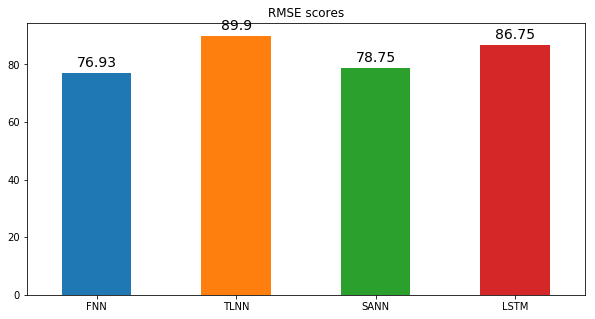

In [99]:
for district in districts_of_interest:
    temp_data = rainfall_season_data[['Date', 'Year', 'Month', district]]
    for month in months_of_interest:
        df = temp_data[temp_data.Month == month]
        df.index = range(len(df))
        df = df[['Date', district]]
        dates = df.Date
        
        rainfall_data = pd.DataFrame({'Precipitation': df[district][:-1*future_steps]})
        rainfall_data.index = dates[:-1*future_steps]
        
        test_rainfall_data = pd.DataFrame({'Precipitation': df[district][-1*future_steps:]})
        test_rainfall_data.index = dates[-1*future_steps:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rainfall_data)

        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        ANN = reload(ANN)
        RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                        parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

        ANN = reload(ANN)
        ANN.save_RMSE_info(output_folder, RMSE_info)

State_predictions/Kolhapur_Jun/
(0, 0, 0)
1447.50889480904
1392.871240394182
1140.1872082836812
1110.616605434263
1325.1389829930927
1299.7655615642038
1117.4447557615558
1112.1294077458654
(0, 0, 1)
1391.7596185962198
1363.2646271124297
1142.1610420892903
1112.513642225489
1324.7382151851045
1301.1127550218644
1118.7428194899344
1113.8792204520219
(0, 1, 0)
1292.4687115227955
1294.4629149382283
1178.8490724904273
1154.23534252926
1294.464697571851
1293.5082893748922
1165.4765332332036
1156.0192472493468
(0, 1, 1)
1234.0985045191248
1236.091432711931
1134.5483532492874
1103.4853748195835
1236.0899638869143
1237.3295288914062
1110.0059997782078
1104.9803529151995
(1, 0, 0)
1305.2533320369034
1306.7338948631107
1142.1234781874457
1112.4818991317616
1306.7774744709232
1309.141299002294
1118.4771139842555
1113.8058125152993
(1, 0, 1)
1141.6523181522066
1114.4801614652931
1121.437982069867
1116.0935883253035
(1, 1, 0)
1259.702490946066
1260.3465334398672
1140.8254291532605
1122.046453263243

969.4750796605917
956.2351236632667
(0, 1, 0)
1109.9448705127836
1111.9174049049877
1024.2002357752995
991.5917770363043
1111.919114610384
1113.7340512199103
1008.1813152352097
993.5490384124772
(0, 1, 1)
1057.8978980998127
1059.189203739412
987.7082734683266
947.3521977569766
1059.128455814342
1060.8198617646296
963.1647768009002
947.8390746184052
(1, 0, 0)
1114.7328595856882
1116.1194673838943
993.3555799117876
954.7619548466744
1116.0043690262867
1106.7360024424622
969.4722042420253
956.2245619969001
(1, 0, 1)
1072.649317016968
1073.9408863012711
995.0414110564741
956.268263803888
1073.88009203719
1076.7250475889048
971.1937731655378
957.0482740558652
(1, 1, 0)
1091.2911077222
1092.9898479433073
1013.163453549274
971.2987823025286
1092.9317861318546
1094.4514624068895
987.057344363467
970.990640223805
(1, 1, 1)
1059.7579691545013
1061.1457230809424
987.9698820859618
949.2938507745313
1061.0943996969354
1063.389526592461
965.084495640617
949.8279298811007
Best SARIMAX(0, 1, 1)x(0, 1,

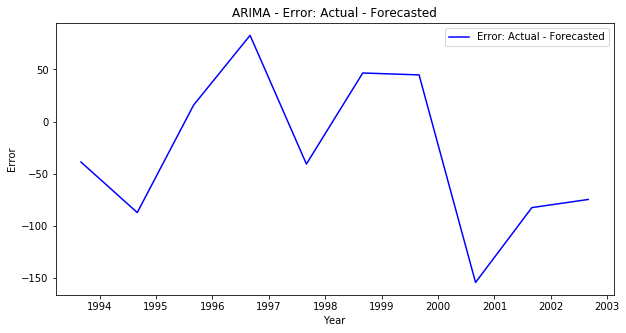

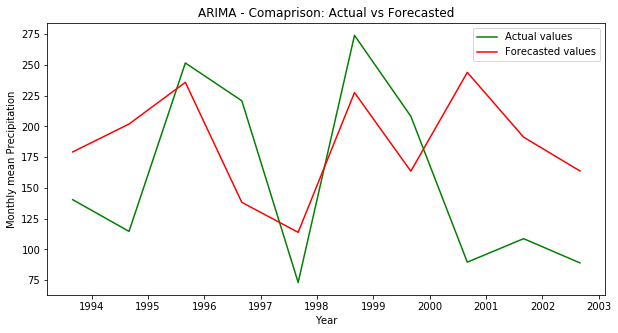

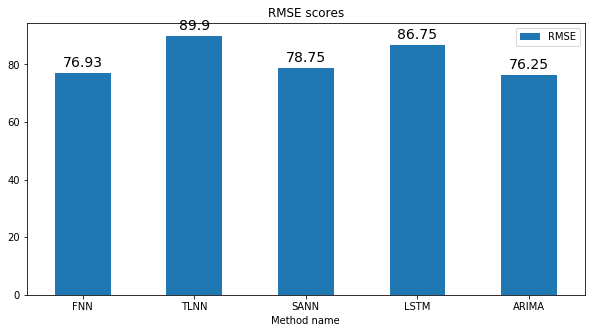

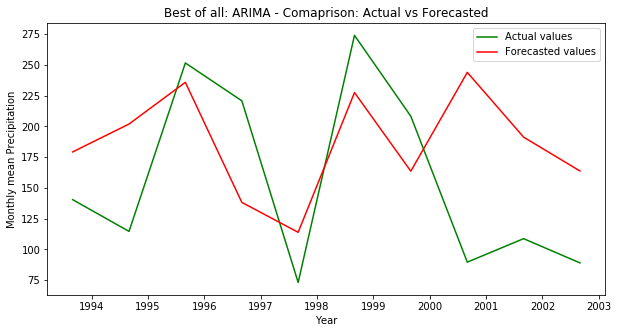

In [100]:
for district in districts_of_interest:
    temp_data = rainfall_season_data[['Date', 'Year', 'Month', district]]
    for month in months_of_interest:
        df = temp_data[temp_data.Month == month]
        df.index = range(len(df))
        df = df[['Date', district]]
        dates = df.Date
        
        rainfall_data = pd.DataFrame({'Precipitation': df[district][:-1*future_steps]})
        rainfall_data.index = dates[:-1*future_steps]
        
        test_rainfall_data = pd.DataFrame({'Precipitation': df[district][-1*future_steps:]})
        test_rainfall_data.index = dates[-1*future_steps:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rainfall_data)

        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        print(output_folder)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        ARIMA = reload(ARIMA)
        forecasted_values = ARIMA.ARIMA(rainfall_data, output_folder, future_steps)

        errors = test_rainfall_data.Precipitation - forecasted_values
        ARIMA_actual_forecasted = pd.DataFrame({'Actual': test_rainfall_data.Precipitation, 
                                               'Forecasted': forecasted_values,
                                               'Errors': errors})
        ARIMA_actual_forecasted.to_csv(output_folder + '/' + 'ARIMA_actual_and_forecasted.csv')

        plt.figure(figsize=(10,5))
        plt.plot(ARIMA_actual_forecasted.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
        plt.xlabel('Year')
        plt.ylabel('Error')
        plt.legend(loc='best')
        plt.title('ARIMA - Error: Actual - Forecasted')
        plt.savefig(output_folder + 'ARIMA_error_plot'  + '.png')

        y_true = test_rainfall_data.ix[:int(future_steps)]
        plt.figure(figsize=(10,5))
        plt.plot(y_true, color='green', label='Actual values')
        plt.plot(forecasted_values, color='red', label='Forecasted values')
        plt.xlabel('Year')
        plt.ylabel('Monthly mean Precipitation')
        plt.legend(loc='best')
        plt.title('ARIMA - Comaprison: Actual vs Forecasted')
        plt.savefig(output_folder + 'ARIMA_best_forecast'  + '.png')

        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values)
        RMSE_score = pd.read_csv(output_folder + 'RMSE_score.csv')
        best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
        RMSE_score = RMSE_score.append({'Unnamed: 0': 'ARIMA', 'RMSE': str(rmse)}, ignore_index=True)
        RMSE_score.RMSE = RMSE_score.RMSE.astype('float')

        current_best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']

        RMSE_score = RMSE_score.set_index('Unnamed: 0')
        RMSE_score.to_csv(output_folder + 'RMSE_score.csv')

        axis = RMSE_score.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')
        axis.set_xlabel('Method name')
        for p in axis.patches:
            axis.annotate(np.round(p.get_height(),decimals=2), 
                        (p.get_x()+p.get_width()/2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), 
                        textcoords='offset points', fontsize=14, color='black')

        fig = axis.get_figure()
        fig.savefig(output_folder + 'RMSE.png')

        if current_best_method == 'ARIMA':
            y_true = test_rainfall_data.ix[:int(future_steps)]
            plt.figure(figsize=(10,5))
            plt.plot(y_true, color='green', label='Actual values')
            plt.plot(forecasted_values, color='red', label='Forecasted values')
            plt.xlabel('Year')
            plt.ylabel('Monthly mean Precipitation')
            plt.legend(loc='best')
            plt.title('Best of all: ARIMA - Comaprison: Actual vs Forecasted')
            plt.savefig(output_folder + 'BEST_FORECAST_ARIMA'  + '.png')
            os.remove(output_folder + 'BEST_FORECAST_' + best_method + '.png')